# Lab 3

**Authors**: Emilio Dorigatti, Tobias Weber

## Imports

In [ ]:
from typing import Any

import torch
from torch.autograd import Function
from torch import Tensor

import matplotlib.pyplot as plt
# from  matplotlib_inline.backend_inline import set_matplotlib_formats
# set_matplotlib_formats('png', 'pdf')

Welcome to the third lab. The first exercise is an implementation of gradient descent
on a bivariate function. The second exercise is about computing derivatives of the
weights of a neural network.

## Exercise 1
This exercise is about gradient descent. We will use the function
$f(x_1, x_2)=(x_1-6)^2+x_2^2-x_1x_2$ as a running example.

Write a function that performs gradient descent. For simplicity, we use a constant learning rate.

In [ ]:
# Note: Defining a custom autograd function is not a necessity for this small task,
# but it is a good place to showcase some capabilities of PyTorch.

class MyFunction(Function):
    @staticmethod
    def forward(ctx: Any, x: Tensor) -> Tensor:
        # The "ctx" object serves to stash information for the backward pass
        ctx.save_for_backward(x)
        func_value = (
            (x[0] - 6)**2 + x[1]**2 - x[0] * x[1]
        )
        return func_value

    @staticmethod
    def backward(ctx: Any, grad_output: Tensor):
        # The "grad_output" parameter is the backpropagated gradient from subsequent
        # operations w.r.t. to the output of this function.
        x = ctx.saved_tensors[0]

        grad_x = torch.tensor([
            2*x[0] - x[1] - 12,
            -x[0] + 2*x[1]
        ])
        return grad_output * grad_x

In [ ]:

func = MyFunction()
# The "required_grad" argument needs to be True.
# Otherwise no gradients will be computed.
x = torch.tensor([6., 6.], requires_grad=True)

# Custom functions are applied over the "apply" method.
y = func.apply(x)
print('Function output: {}'.format(y))

# Gradients for every operation in this chain are computed
# by calling the "backward" method on the output tensor.
y.backward()

# The x tensor now has a grad attribute with the gradients.
print('Gradients: {}'.format(x.grad))

# Note: No usage of auto differentiation was done in this example.

Function output: 0.0
Gradients: tensor([-6.,  6.])


In the next step we define a small gradient descent optimizer.

In [ ]:

class GradientDescentOptimizer:
    def __init__(self,
                 func: Function,
                 max_steps: int,
                 alpha: float):
        """
        Init an Optimizer for performing GD.

        :param func: Function to apply.
        :param max_steps: Maximum number of GD steps.
        :param alpha: Learning Rate.
        """
        self.func = func
        self.max_steps = max_steps
        self.alpha = alpha

    def __call__(self, x: Tensor) -> Tensor:
        """
        Apply GD on a tensor.

        :param x: Input tensor.
        """
        # Usually you would apply the gradients inplace on the input tensor,
        # but for the sake of the example we keep the input tensor consistent and
        # work on a copy.
        x_cp = x.detach().clone()
        x_cp.requires_grad = True

        # Dummy value for initial loop.
        y_old = torch.tensor([float('inf')])

        for i in range(self.max_steps):
            # Set gradients of x to None
            x_cp.grad = None

            # Compute function output
            y = func.apply(x_cp)

            # Compute gradients
            y.backward()

            # Apply gradients
            # We need "no_grad" as otherwise the autodiff engine will compute
            # gradients for this operation.
            with torch.no_grad():
                x_cp.data -= self.alpha * x_cp.grad

            # Check if we reached some point of convergence.
            if y_old - y < 1e-4:
                break
            y_old = y
        return x_cp

In [ ]:
x = torch.tensor([6., 6.], requires_grad=True)
gd_optimizer = GradientDescentOptimizer(func=MyFunction(), max_steps=10, alpha=0.1)
x_new = gd_optimizer(x)
print(x_new)

tensor([7.9435, 4.0565], requires_grad=True)


RuntimeError: ignored

Play a bit with the starting point and learning rate to get a feel for its behavior.
How close can you get to the minimum?

## Exercise 2

This exercise is about computing gradients with the chain rule.
We will work with a neural network with a single hidden layer with two neurons and an
output layer with one neuron.

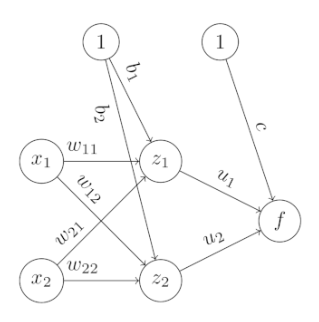

The neurons in the hidden layer use the $\tanh$ activation, while the output neuron uses
the sigmoid. The loss used in binary classification is the _binary cross-entropy_:

$$
\mathcal{L}(y, f_{out})=-y\log f_{out}-(1-y)\log(1-f_{out})
$$

where $y\in\{0,1\}$ is the true label and $f_{out}\in(0,1)$ is the predicted probability that $y=1$.

 1. Compute $\partial\mathcal{L}(y, f_{out})/\partial f_{out}$
 2. Compute $\partial f_{out}/\partial f_{in}$
 3. Show that $\partial\sigma(x)/\partial x=\sigma(x)(1-\sigma(x))$
 4. Show that $\partial\tanh(x)/\partial x=1-\tanh(x)^2$ (Hint: $\tanh(x)=(e^x-e^{-x})(e^x+e^{-x})^{-1}$)
 5. Compute $\partial f_{in}/\partial c$
 6. Compute $\partial f_{in}/\partial u_1$
 7. Compute $\partial\mathcal{L}(y,  f_{out})/\partial c$
 8. Compute $\partial\mathcal{L}(y,  f_{out})/\partial u_1$
 9. Compute $\partial f_{in}/\partial z_{2,out}$
 10. Compute $\partial z_{2,out}/\partial z_{2,in}$
 11. Compute $\partial z_{2,in}/\partial b_2$
 12. Compute $\partial z_{2,in}/\partial w_{12}$
 13. Compute $\partial z_{2,in}/\partial x_1$
 14. Compute $\partial\mathcal{L}(y,  f_{out})/\partial b_2$
 15. Compute $\partial\mathcal{L}(y,  f_{out})/\partial w_{12}$
 16. Compute $\partial\mathcal{L}(y,  f_{out})/\partial x_1$

Now that we know how to do gradient descent and how to compute the derivatives of the
weights of a simple network, we can try to do these steps together and train our first
neural network! We will use the small dataset with five points we studied in the first
lab.

First, let's define the dataset:

In [ ]:
x = torch.tensor([
    [0, 0],
    [1, 0],
    [0, -1],
    [-1, 0],
    [0, 1]
], dtype=torch.float)
y = torch.tensor([1, 0, 0, 0, 0])

Next, a function to compute the output of the network:

In [ ]:

def sigmoid(x: Tensor) -> Tensor:
    return 1 / (1 + torch.exp(-x))

def predict(x: Tensor, b1: float, b2: float,
            w11: float, w12: float, w21: float, w22: float,
            c: float, u1: float, u2:float) -> Tensor:
    z1 = torch.tanh(b1 + x[:, 0] * w11 + x[:, 1] * w21)
    z2 = torch.tanh(b2 + x[:, 0] * w12 + x[:, 1] * w22)
    return sigmoid(c + u1 * z1 + u2 * z2)

# This should return the predictions for the five points in the datasets
# We can unpack the param vector for the positional params of the function so that we don't
# need to enter every single entry.
params = torch.randn(9)
predictions = predict(x, *params)

Since gradient descent is done on the loss function, we need a function to compute it:

In [ ]:

def get_loss(target: Tensor, pred: Tensor) -> Tensor:
    return -torch.mean(target * torch.log(pred + 1e-15) +
                       (1 - target) * torch.log(1 - pred + 1e-15))

loss = get_loss(y, predictions)
print(loss)

tensor(0.8185)


Now, we need to compute the gradient of each parameter:

In [ ]:

def get_gradients(x: Tensor, target: Tensor,
            b1: float, b2: float,
            w11: float, w12: float, w21: float, w22: float,
            c: float, u1: float, u2:float) -> Tensor:
    # First, we perform the forward pass.
    z1in = b1 + x[:, 0] * w11 + x[:, 1] * w21
    z1out = torch.tanh(z1in)

    z2in = b2 + x[:, 0] * w12 + x[:, 1] * w22
    z2out = torch.tanh(z2in)

    fin = c + u1 * z1out + u2 * z2out
    fout = sigmoid(fin)


    # Now we start back-propagation through the loss and the output neuron.
    dL_dfout = -target / (fout + 1e-15) + (1 - target) / (1 - fout + 1e-15)
    dfout_dfin = sigmoid(fin) * (1 - sigmoid(fin))

    # Compute the gradients for the parameters of the output layer.
    dfin_dc = 1
    dfin_du1 = z1out
    dfin_du2 = z2out

    # Take the mean gradient across data points
    dL_dc = torch.mean(dL_dfout * dfout_dfin * dfin_dc)
    dL_du1 = torch.mean(dL_dfout * dfout_dfin * dfin_du1)
    dL_du2 = torch.mean(dL_dfout * dfout_dfin * dfin_du2)

    # Back-propagate through the neurons in the first hidden layer.
    dfin_dz1out = u1
    dfin_dz2out = u2

    dz1out_dz1in = 1. - torch.tanh(z1in)**2
    dz2out_dz2in = 1. - torch.tanh(z2in)**2

    # Compute the derivatives of the parameters of the hidden layer.
    dz1in_db1 = dz2in_db2 = 1
    dL_db1 = torch.mean(dL_dfout * dfout_dfin * dfin_dz1out * dz1out_dz1in * dz1in_db1)
    dL_db2 = torch.mean(dL_dfout * dfout_dfin * dfin_dz2out * dz2out_dz2in * dz2in_db2)

    dz1in_dw11 = dz2in_dw12 = x[:, 0]
    dL_dw11 = torch.mean(dL_dfout * dfout_dfin * dfin_dz1out * dz1out_dz1in * dz1in_dw11)
    dL_dw12 = torch.mean(dL_dfout * dfout_dfin * dfin_dz2out * dz2out_dz2in * dz2in_dw12)

    dz1in_dw21 = dz2in_dw22 = x[:, 1]
    dL_dw21 = torch.mean(dL_dfout * dfout_dfin * dfin_dz1out * dz1out_dz1in * dz1in_dw21)
    dL_dw22 = torch.mean(dL_dfout * dfout_dfin * dfin_dz2out * dz2out_dz2in * dz2in_dw22)


    # Return the derivatives in the same order as the parameters vector
    return torch.stack([
        dL_db1, dL_db2, dL_dw11, dL_dw12, dL_dw21, dL_dw22, dL_dc, dL_du1, dL_du2
    ])

print(get_gradients(x, y, *params))

tensor([-0.1230,  0.0845, -0.0209,  0.0541, -0.0052,  0.0298,  0.3481, -0.0881,
        -0.0897])


Finite differences are a useful way to check that the gradients are computed correctly:

In [ ]:

# First, compute the analytical gradient of the parameters.
gradient = get_gradients(x, y, *params)
eps = 1e-9
for i in range(9):
    # Compute loss when subtracting eps to parameter i.
    neg_params = params.clone()
    neg_params[i] = neg_params[i] - eps
    neg_value = get_loss(y, predict(x, *neg_params))

    # Compute loss when adding eps to parameter i.
    pos_params = params.clone()
    pos_params[i] = pos_params[i] + eps
    pos_value = get_loss(y, predict(x, *pos_params))

    # Compute the "empirical" gradient of parameter i
    fdiff_gradient = torch.mean((pos_value - neg_value) / (2 * eps))

    # Error if difference is too large
    if torch.abs(gradient[i] - fdiff_gradient) < 1e-5:
        raise ValueError('Gradients are probably wrong!')

print("Gradients are correct!")

Gradients are correct!


We can finally train our network. Since the network is so small compared to the dataset,
 the training procedure is very sensitive to the way the weights are initialized and
 the step size used in gradient descent.

Try to play around with the learning rate and the random initialization of the weights
and find reliable values that make training successful in most cases.

In [ ]:

min_loss = 10
alpha = 1.
steps = 100
best_params = None

for i in range(10):
    params = torch.randn(9)

    # Do GD
    for _ in range(steps):
        gradients = get_gradients(x, y, *params)
        params -= alpha * gradients

    final_loss = get_loss(y, predict(x, *params))
    print('RUN {} \t LOSS {:.4f}'.format(i + 1, float(final_loss)))

    if final_loss < min_loss:
        best_params = params
        min_loss = final_loss

RUN 1 	 LOSS 0.4066
RUN 2 	 LOSS 0.3967
RUN 3 	 LOSS 0.4025
RUN 4 	 LOSS 0.4999
RUN 5 	 LOSS 0.1311
RUN 6 	 LOSS 0.4572
RUN 7 	 LOSS 0.0509
RUN 8 	 LOSS 0.0862
RUN 9 	 LOSS 0.4687
RUN 10 	 LOSS 0.2917


We can use the function in the previous lab to visualize the decision boundary of
the best network:

In [ ]:

def plot_decision_boundary(
        x: Tensor, y: Tensor, grid_x: Tensor, grid_y, pred: Tensor) -> None:
    """Plot the estimated decision boundary for a 2D grid with predictions."""
    plt.contourf(grid_x, grid_y, pred.view(grid_x.shape))
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap='jet')
    plt.show()

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


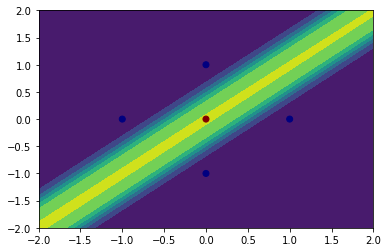

In [ ]:

grid_range = torch.linspace(-2, 2, 50)
grid_x, grid_y = torch.meshgrid(grid_range, grid_range)
grid_data = torch.stack([grid_x.flatten(), grid_y.flatten()]).T
pred = predict(grid_data, *best_params)

plot_decision_boundary(x, y, grid_x, grid_y, pred)



Also try to visualize the decision boundary of network with random parameters:

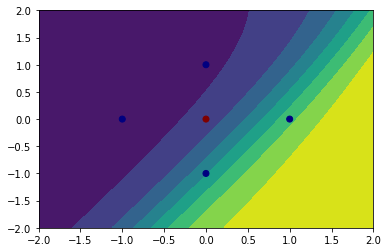

In [ ]:
pred = predict(grid_data, *torch.randn(9))
plot_decision_boundary(x, y, grid_x, grid_y, pred)